In [1]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange, tqdm

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    has_all_transitions,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
# import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

random.seed(0)
torch.manual_seed(0)

GPU not available, CPU used


In [2]:
nonlinearity, lr, P, L, n_epochs = "tanh", 0.0003, 100, 1, 12500

N_gain, N_p = 10, 10
max_seq_len = 8
max_gain = 2.0
max_p = 1

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
problem = lambda seq: np.sum(seq) % 2  # XOR problem

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
val_seq_length = 100
val_datapoints = 30
analysis_seq_lengths = list(range(1, max_seq_len + 1))

In [3]:
gain = 0.000000001
lr = 0.001
n_epochs = 1000000
P = 100

In [4]:
gain = 0.000000001
lr = 0.00025
n_epochs = 10000000
P = 100

In [5]:
def trial(gain, p):
    ## Generate data

    # Generate datasets
    # training_datasets = [
    #     seq_data(device, problem, encoding, seq_len=length)
    #     for length in train_seq_lengths
    # ]
    training_datasets = []
    for length in range(1, max_seq_len + 1):
        n = np.random.binomial(2**length, p)
        if n == 0:
            continue
        data = seq_data(device, problem, encoding, seq_len=length, n_datapoints=n)
        training_datasets.append(data)
    validation_datasets = [
        seq_data(
            device,
            problem,
            encoding,
            n_datapoints=val_datapoints,
            seq_len=val_seq_length,
        )
    ]
    analysis_data = [
        seq_data(device, problem, encoding, seq_len=length)
        for length in analysis_seq_lengths
    ]
    tracked_datasets = validation_datasets + training_datasets

    ## Instantiate model
    model = Model(
        encoding=encoding,
        input_size=2,
        output_size=2,
        hidden_dim=P,
        n_layers=L,
        device=device,
        nonlinearity=nonlinearity,
        gain=gain,
    )

    ## Setup compiler
    criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, amsgrad=True, weight_decay=0
    )
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    }

    ## Training run
    compiler.training_run(
        training_datasets,
        n_epochs=n_epochs,
        batch_size=128,
        progress_bar=False,
        conv_thresh=0.0001
    )

    ## Collect data
    loss = compiler.trackers["loss"].get_trace()
    val_loss = loss.query("Dataset==0")[0].to_numpy()[-1]
    train_loss = loss.query("Dataset>0").groupby("Epoch").mean().to_numpy()[-1]
    initial_hidden = model.init_hidden(batch_size=1)[-1]
    hidden_function = lambda inputs: model(inputs)[1][-1]
    output_function = lambda inputs: model(inputs)[0]
    automaton = to_automaton(
        hidden_function,
        output_function,
        initial_hidden,
        analysis_data,
        encoding,
        merge_distance_frac=0.1,
    )
    n_states = len(automaton.states)
    is_finite = automaton.is_finite()
    n_exit = sum(
        not has_all_transitions(state, automaton.transition_function)
        for state in automaton.states
    )

    val_loader = torch.utils.data.DataLoader(validation_datasets[0], batch_size=128)
    correct = 0
    for x, y in val_loader:
        predictions = torch.argmax(model(x)[0], axis=1)
        targets = torch.argmax(y, axis=1)
        correct += sum(predictions == targets)
    val_acc = (correct / len(validation_datasets[0])).item()

    return train_loss, val_loss, val_acc, n_states, is_finite, n_exit

In [6]:
gains = np.linspace(0.1, max_gain, N_gain)
seq_lens = np.linspace(0.1, max_p, N_p)
(
    gain_data,
    seq_len_data,
    train_loss_data,
    val_loss_data,
    val_acc_data,
    n_states_data,
    is_finite_data,
    n_exit_data,
) = [[] for _ in range(8)]

for gain in tqdm(gains):
    for seq_len in seq_lens:

        train_loss, val_loss, val_acc, n_states, is_finite, n_exit = trial(
            gain, seq_len
        )
        for data, item in zip(
            (
                gain_data,
                seq_len_data,
                train_loss_data,
                val_loss_data,
                val_acc_data,
                n_states_data,
                is_finite_data,
                n_exit_data,
            ),
            (gain, seq_len, train_loss, val_loss, val_acc, n_states, is_finite, n_exit),
        ):
            data.append(item)

  0%|          | 0/10 [00:00<?, ?it/s]/nfs/ghome/live/vanrosseml/mambaforge/envs/rnn_structure/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

Computing automata: 100%|█████████

In [7]:
for data, name in zip(
    (
        gain_data,
        seq_len_data,
        train_loss_data,
        val_loss_data,
        val_acc_data,
        n_states_data,
        is_finite_data,
        n_exit_data,
    ),
    (
        "gain",
        "seq_len",
        "train_loss",
        "val_loss",
        "val_acc",
        "n_states",
        "is_finite",
        "n_exit",
    ),
):
    np.save("plots/" + name, data)

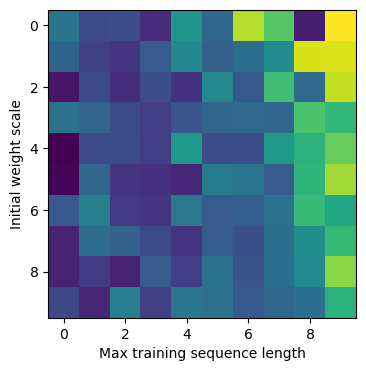

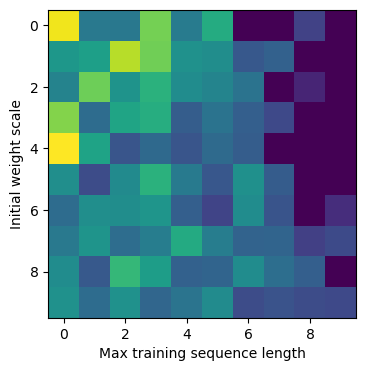

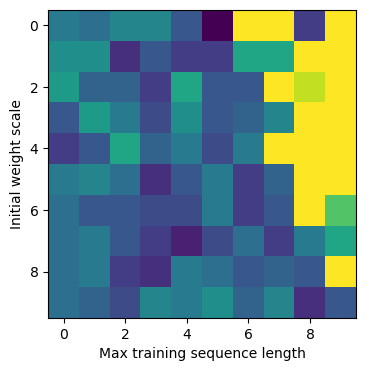

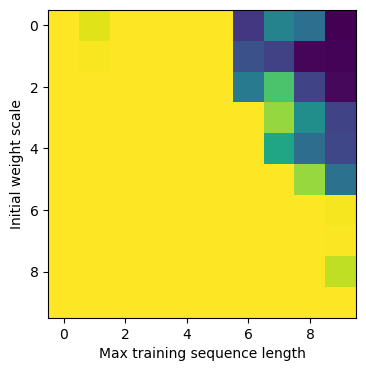

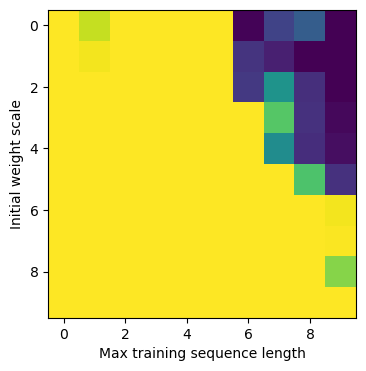

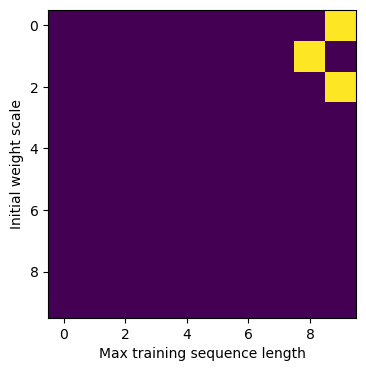

In [8]:
# n_states_total = np.array([sum(2**i for i in range(len + 1)) for len in seq_len_data])
# n_states_norm = n_states_data / n_states_total
N_len = N_p

## Plot results
# publication.set_color_gradient(2)

train_loss_grid = np.array(train_loss_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(train_loss_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/train_loss_grid",
# )
plt.show()

val_loss_grid = np.array(val_loss_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(val_loss_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/val_loss_grid",
# )
plt.show()

val_acc_grid = np.array(val_acc_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(val_acc_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/val_acc_grid",
# )
plt.show()

n_states_grid = np.array(n_states_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(n_states_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/n_states_grid",
# )
plt.show()

n_exit_grid = np.array(n_exit_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(n_exit_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/n_exit_grid",
# )
plt.show()

is_finite_grid = np.array(is_finite_data).reshape(N_gain, N_len)
fig = plt.figure(figsize=(4, 4))
plt.imshow(is_finite_grid)
plt.xlabel("Max training sequence length")
plt.ylabel("Initial weight scale")
# publication.im_show(
#     colorbar=True,
#     x_labels=seq_lens,
#     y_labels=np.around(gains, 1),
#     save_path="plots/is_finite_grid",
# )
plt.show()

NameError: name 'publication' is not defined

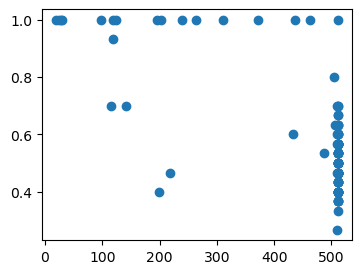

In [9]:
plt.figure(figsize=(4, 3))
plt.scatter(n_states_data, val_acc_data)
publication.pub_show()

In [ ]:
(
    gain_data,
    seq_len_data,
    train_loss_data,
    val_loss_data,
    val_acc_data,
    n_states_data,
    is_finite_data,
    n_exit_data,
) = [
    np.load(f"plots/{name}.npy")
    for name in (
        "gain",
        "seq_len",
        "train_loss",
        "val_loss",
        "val_acc",
        "n_states",
        "is_finite",
        "n_exit",
    )
]